In [1]:
from functools import reduce

import warnings
import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scikitplot.metrics import plot_roc,plot_ks_statistic
from sklearn.ensemble import RandomForestClassifier

cf.go_offline()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
ruta='/home/asm/amv/credit_scoring/datos/GiveMeSomeCredit'
df=pd.read_csv(ruta+'/cs-training.csv',index_col=0)
df.reset_index(drop=True,inplace=True)
df.insert(0,'ID',df.index+1)
df.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
target=['SeriousDlqin2yrs']

um=['ID']

varc=['RevolvingUtilizationOfUnsecuredLines']

vard=['NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse',
      'NumberOfTime60-89DaysPastDueNotWorse','age']

df=df[um+target+varc+vard]

## Segmentación con árboles de decisión

In [4]:
df[varc+vard].isna().sum() # no hay nulos

RevolvingUtilizationOfUnsecuredLines    0
NumberOfTimes90DaysLate                 0
NumberOfTime30-59DaysPastDueNotWorse    0
NumberOfTime60-89DaysPastDueNotWorse    0
age                                     0
dtype: int64

In [5]:
tree=DecisionTreeClassifier(max_depth=1)
tree.fit(df[varc+vard],df[target])

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'NumberOfTimes90DaysLate <= 0.5\ngini = 0.125\nsamples = 100.0%\nvalue = [0.933, 0.067]\nclass = 0'),
 Text(0.25, 0.25, 'gini = 0.088\nsamples = 94.4%\nvalue = [0.954, 0.046]\nclass = 0'),
 Text(0.75, 0.25, 'gini = 0.486\nsamples = 5.6%\nvalue = [0.584, 0.416]\nclass = 0')]

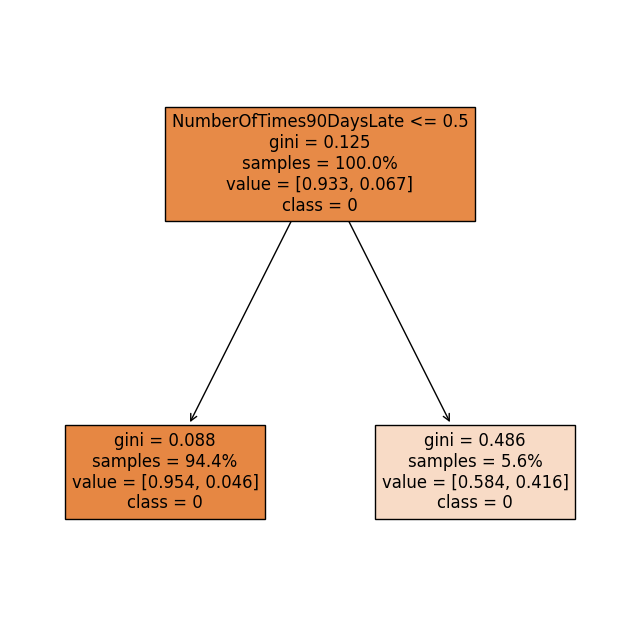

In [6]:
fig,ax=plt.subplots(figsize=(8,8))
plot_tree(tree,feature_names=varc+vard,class_names=['0','1'],filled=True,ax=ax,proportion=True)

In [7]:
df['segmento']=np.where(df['NumberOfTimes90DaysLate']<=.5,0,1)

## Descripción de los segmentos

In [8]:
df['segmento'].value_counts(1) # proporción de cada segmento

segmento
0    0.944413
1    0.055587
Name: proportion, dtype: float64

In [9]:
pd.crosstab(df['segmento'],df['SeriousDlqin2yrs'],normalize='index') # porcentaje de buenos y malos por segmento

SeriousDlqin2yrs,0,1
segmento,,
0,0.953735,0.046265
1,0.583593,0.416407


In [10]:
df[target].value_counts(normalize=True) # porcentaje de buenos y malos en la población

SeriousDlqin2yrs
0                   0.93316
1                   0.06684
Name: proportion, dtype: float64

In [11]:
df[df['segmento']==0][varc+vard].describe().round(2) 
# estadísticas de las variables pora el segmento 0

,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age
count,141662.00,141662.0,141662.00,141662.00,141662.00
mean,6.15,0.0,0.20,0.04,52.67
std,250.71,0.0,0.61,0.25,14.78
min,0.00,0.0,0.00,0.00,0.00
25%,0.03,0.0,0.00,0.00,42.00
50%,0.14,0.0,0.00,0.00,52.00
75%,0.49,0.0,0.00,0.00,63.00
max,50708.00,0.0,13.00,9.00,109.00


In [12]:
df[df['segmento']==1][varc+vard].describe().round(2) 
# estadísticas de las variables pora el segmento 1

,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age
count,8338.00,8338.00,8338.00,8338.00,8338.00
mean,4.41,4.78,4.12,3.62,45.99
std,233.04,17.06,17.19,17.25,13.16
min,0.00,1.00,0.00,0.00,21.00
25%,0.49,1.00,0.00,0.00,36.00
50%,0.95,1.00,1.00,0.00,46.00
75%,1.00,2.00,2.00,1.00,55.00
max,20514.00,98.00,98.00,98.00,97.00


* cluster 0: Adultos mayores que han presentado pocos atrasos en el pago de sus créditos y tienen un RevolvingUtilizationOfUnsecuredLines bajo (tienen limite de credito alto)
* cluster 2: Personas jovenes que han presentado atrasos en el pago de sus créditos y tienen un RevolvingUtilizationOfUnsecuredLines de 1 (limite de credito igual al sado en su tarjeta de credito)) 

## Segmentación

In [13]:
s0=df[df['segmento']==0].reset_index(drop=True)
s1=df[df['segmento']==1].reset_index(drop=True)

### Modelo del segmento 0

In [14]:
train0,test0=train_test_split(s0,test_size=0.3,random_state=1234,stratify=s0[target])
train0.reset_index(drop=True,inplace=True)
test0.reset_index(drop=True,inplace=True)
train0.shape,test0.shape

((99163, 8), (42499, 8))

In [15]:
modelo0=RandomForestClassifier()
grid={'n_estimators':range(20,201,20),'max_depth':range(2,6),'criterion':['gini','entropy'],'class_weight':['balanced',None],'max_features':['sqrt','log2'],'n_jobs':[-1],'random_state':[1234]}
gs0=RandomizedSearchCV(modelo0,grid,n_iter=50,scoring='roc_auc',n_jobs=-1,random_state=1234)
gs0.fit(train0[varc+vard],np.ravel(train0[target]))
modelo0=gs0.best_estimator_
modelo0

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=160,
                       n_jobs=-1, random_state=1234)

In [16]:
roc_auc_score(train0[target],modelo0.predict_proba(train0[varc+vard])[:,1]),roc_auc_score(test0[target],modelo0.predict_proba(test0[varc+vard])[:,1])

(0.8187623438587854, 0.8059268123565795)

### Modelo del segmento 1

In [17]:
train1, test1 = train_test_split(s1, test_size=0.3, random_state=1234, stratify=s1[target])
train1.reset_index(drop=True, inplace=True)
test1.reset_index(drop=True, inplace=True)
train1.shape, test1.shape

((5836, 8), (2502, 8))

In [18]:
modelo1=RandomForestClassifier()
gs1 = RandomizedSearchCV(modelo1, grid, n_iter=50, scoring='roc_auc', n_jobs=-1, random_state=1234)
gs1.fit(train1[varc+vard], np.ravel(train1[target]))
modelo1 = gs1.best_estimator_
modelo1

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=160,
                       n_jobs=-1, random_state=1234)

In [19]:
roc_auc_score(train1[target], modelo1.predict_proba(train1[varc+vard])[:, 1]),roc_auc_score(test1[target], modelo1.predict_proba(test1[varc+vard])[:, 1])

(0.7165105635419461, 0.6927050193253227)

## Aplicación de los modelos

In [20]:
s0[['proba_0','proba_1']]=modelo0.predict_proba(s0[varc+vard])
s1[['proba_0','proba_1']]=modelo1.predict_proba(s1[varc+vard])

In [21]:
tad=pd.concat([s0,s1],axis=0).reset_index(drop=True)
tad.head()

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age,segmento,proba_0,proba_1
0,1,1,0.766127,0,2,0,45,0,0.777868,0.222132
1,2,0,0.957151,0,0,0,40,0,0.904707,0.095293
2,4,0,0.233810,0,0,0,30,0,0.972620,0.027380
3,5,0,0.907239,0,1,0,49,0,0.832249,0.167751
4,6,0,0.213179,0,0,0,74,0,0.985824,0.014176


In [22]:
roc_auc_score(tad[target],tad['proba_1'])

0.8583374212516187

In [23]:
pred=pd.read_csv(ruta+'/cs-test.csv')
pred['segmento']=np.where(pred['NumberOfTimes90DaysLate']<=.5,0,1)
pred['Id']=pred.index+1
pred['Probability']=np.where(pred['segmento']==0,modelo0.predict_proba(pred[varc+vard])[:,1],modelo1.predict_proba(pred[varc+vard])[:,1])
pred[['Id','Probability']].to_csv(ruta+'/pred_segmentacion_árbol.csv',index=False)
pred.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,segmento,Id,Probability
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,0,1,0.095128
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,0,2,0.032754
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,0,3,0.010670
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,0,4,0.074197
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,0,5,0.096063
